**Functional API**<br/>
The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
lr = 1e-3 # Can also be a learning rate schedule, providing decay.
optimizer = tf.keras.optimizers.RMSprop(lr)
loss_fn = tf.keras.losses.CategoricalCrossentropy() #Note the differnce between categorical cross entropy and sparse categorical cross entropy.

In [ ]:
#ResNet Model on CiFar10 dataset, for CiFar10 input shape is (32, 32, 3)
def get_compiled_model():
  inputs = tf.keras.Input(shape=(32, 32, 3), name="img")
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation="relu")(inputs)
  x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
  block_1_output = tf.keras.layers.MaxPooling2D(3)(x)

  x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
  x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_2_output = tf.keras.layers.add([x, block_1_output])

  x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
  x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_3_output = tf.keras.layers.add([x, block_2_output])

  x = tf.keras.layers.Conv2D(64, 3, activation="relu")(block_3_output)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(256, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

  model =  tf.keras.Model(inputs, outputs, name="toy_resnet")
  model.compile(optimizer = optimizer, loss = loss_fn, metrics = ["acc"])
  return model

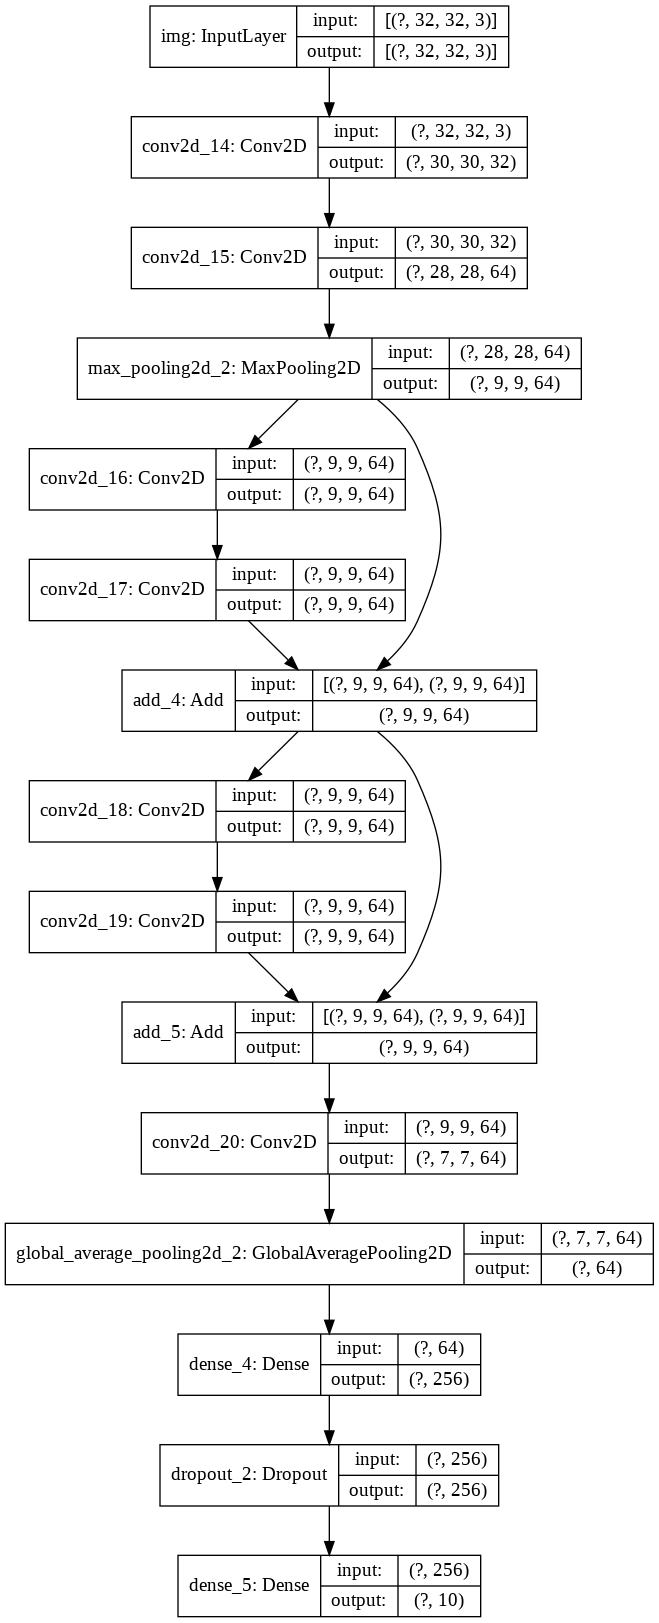

In [ ]:
tf.keras.utils.plot_model(get_compiled_model(), show_shapes = True)

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10) #convert to one hot, since we will be using categorical cross entropy.
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return tf.keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100 # can also use periods arguement to save on epoch basis.
    )
]
history = model.fit(x_train[:15000], y_train[:15000], epochs=15, validation_split = 0.3, callbacks=callbacks) #Also add saving complete model, model checkpointing only stores the

Creating a new model
Epoch 1/15
 97/329 [=======>......................] - ETA: 3s - loss: 2.2763 - acc: 0.1350WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=2.27/assets
329/329 [==============================] - 10s 29ms/step - loss: 2.1259 - acc: 0.1886 - val_loss: 1.9445 - val_acc: 0.2396
Epoch 2/15
329/329 [==============================] - 9s 28ms/step - loss: 1.8363 - acc: 0.3020 - val_loss: 1.7733 - val_acc: 0.3040
Epoch 3/15
329/329 [==============================] - 9s 28ms/step - loss: 1.6342 - acc: 0.3875 -

In [ ]:
#to remove the checkpoint directory if it is non-empty

# import shutil

# shutil.rmtree(checkpoint_dir) 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


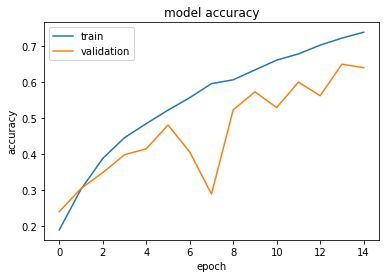

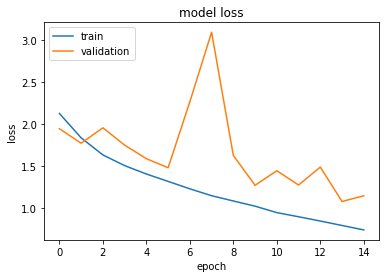

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5') 

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_22[0][0]                  
_________________________________________________________________________________________

In [ ]:
loss, acc = new_model.evaluate(x_test,  y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

313/313 - 2s - loss: 1.1350 - acc: 0.6443
Restored model, accuracy: 64.43%
